In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib import colors as mcolors
import scipy
from scipy.stats import ttest_1samp, ttest_rel, ttest_ind
from statsmodels.stats.anova import AnovaRM
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [28]:
from IPython.display import Image, display

In [3]:
import warnings

In [4]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [5]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [6]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [7]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [8]:
dname = join(dir_git,'AnatSearchlight')
sys.path.append(dname)
import AnatSearchlight.searchlight as sl

In [9]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [10]:
mpl.rcParams['font.family'] = 'Helvetica'

## Font를 못 읽어 온다면, matplotlib 캐시 초기화
`rm -rf ~/.cache/matplotlib`

---

In [11]:
list_sn = su.get_list_sn()
# list_roi = simage.get_list_roi()
list_run = su.get_list_run()

In [12]:
dir_group = join(ssingle.get_dir_glmsingle(),'surfaceWB/group')
dir_group

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group'

---

In [13]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

In [14]:
dir_group = join(dir_surf,'group')

---

|(K,P)|ch $_{1}$|ch $_{2}$|$\cdots$|$i^{th}$ profile|$\cdots$|ch $_{P-1}$|ch $_{P}$| 
|-----|-----|-----|-----|-----|-----|-----|-----|
|cond $_{1}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|cond $_{2}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|$\vdots$|$\vdots$|$\vdots$|$\ddots$|$\vdots$|$\ddots$|$\cdot$|$\cdot$|
|$j^{th}$ pattern|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|$\vdots$|$\vdots$|$\vdots$|$\ddots$|$\vdots$|$\ddots$|$\cdot$|$\cdot$|
|cond $_{K-1}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|cond $_{K}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|

1) Whole Brain: Pattern Analysis
2) ROI: Profile Analysis

In [15]:
dir_roi = su.get_dir_roi()

In [16]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')
hem = 'L'

In [17]:
# fname = join(dir_roi, 'SPark.32k.L.dlabel.nii')
# cii = nb.load(fname)
# mask = cii.get_fdata()[0].astype(int)

fname = join(dir_roi,'SPark2025.32k.L.label.gii')
gii = nb.load(fname)
mask = gii.darrays[0].data

In [18]:
list_roi = []
for ii, label in enumerate(gii.labeltable.labels):
    if ii>0:
        list_roi.append(label.label)
list_roi = np.array(list_roi)
list_roi

array(['S1', 'M1', 'SMA', 'PMd', 'PMv', 'SPLa', 'SPLp', 'IPS', 'V4d',
       'Vf', 'Vd', 'Vv', 'POS', 'PGi'], dtype='<U4')

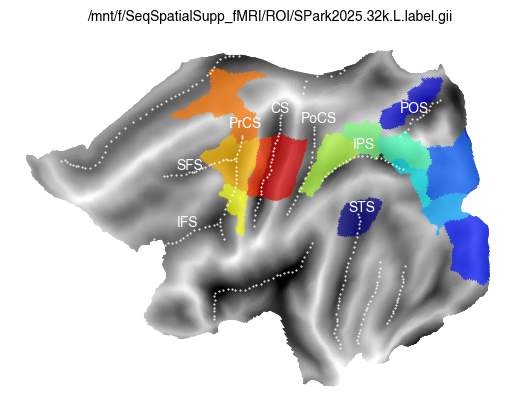

In [19]:
g = surf.plot.plotmap(
    data=mask,
    surf='fs32k_%s'%hem,
    alpha=0.7,
    cmap=cm.jet_r.resampled(len(np.unique(mask))),
    # colorbar=True,
    # cscale=[-1,7],
    # threshold=[-thresh,thresh],
    borders=border, bordercolor='white', bordersize=1,
    overlay_type='func', render='matplotlib',
)
g.text(x=20, y=220, s=fname, ha='center', va='center', fontsize=10)
for line, (x, y) in brdr.items():
    g.text(x=x, y=y, s=line, ha='left', va='bottom', color='white', fontsize=10)

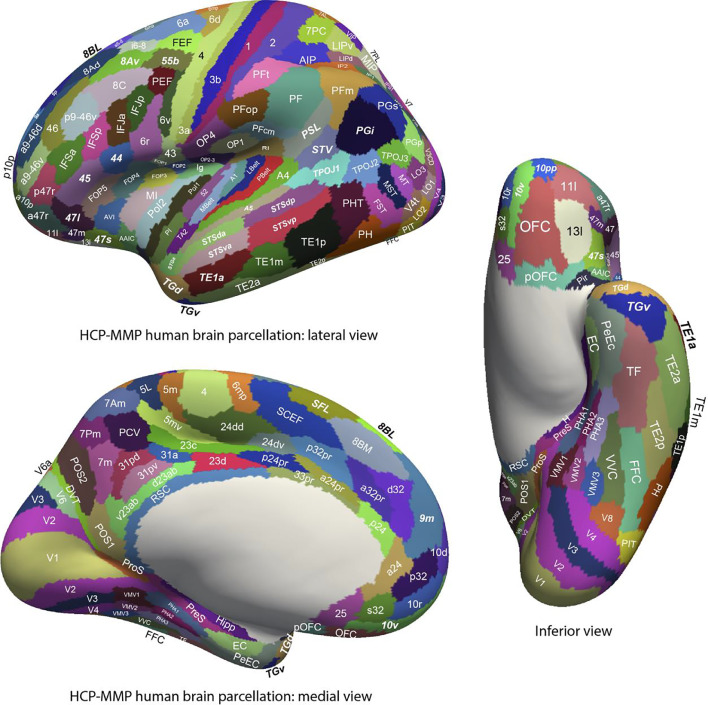

In [29]:
display(Image(filename='../figures/1-s2.0-S1053811922004712-gr1.jpg'))

---
---

In [20]:
def extract_data(data, mask, list_roi):
    result = {}
    for ii, roi in enumerate(list_roi):
        assert data.shape[-1] == mask.shape[0]
        val = ii+1
        idx = mask==val

        result[roi] = data[:,idx].mean(axis=-1)

    return result

In [21]:
df = pd.DataFrame()

## 1. Overall Activity

In [22]:
lines = {'category':[],'roi':[],'cond':[],'subj':[],'value':[],'notes':[]}

In [23]:
glm = 1
category = 'overall'

In [24]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [25]:
notes = None
for ii, cue in enumerate(['letter','spatial']):
    fname = join(dir_work,'smooth.cifti.%s.glm_%1d.beta_mean.%s.dscalar.nii'%(hem,glm,cue))
    cii = nb.load(fname)
    data = cii.get_fdata()
    res = extract_data(data=data, mask=mask, list_roi=list_roi)
    for roi, values in res.items():
        for jj, value in enumerate(values):
            sn = list_sn[jj]
            subj = 'S'+sn
            lines['category'].append(category)
            lines['roi'].append(roi)
            lines['cond'].append(cue)
            lines['subj'].append(subj)
            lines['value'].append(value)
            lines['notes'].append(notes)
dg = pd.DataFrame(lines)

 57%|█████████████████████████████▋                      | 8/14 [00:00<00:00, 38.16it/s]

S1
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 11.9695 1.0000 11.0000 0.0053

t(11)=3.4597, p=0.0053(**)

M1
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  9.3617 1.0000 11.0000 0.0109

t(11)=3.0597, p=0.0109(*)

SMA
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 17.4234 1.0000 11.0000 0.0016

t(11)=4.1741, p=0.0016(**)

PMd
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  7.6470 1.0000 11.0000 0.0184

t(11)=2.7653, p=0.0184(*)

PMv
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 38.3324 1.0000 11.0000 0.0001

t(11)=6.1913, p=0.0001(****)

SPLa
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  5.8223 1.0000 11.0000 0.0344

t(11)=2.4130, p=0.0344(*)

SPLp
              Anova
     F Value Num DF  Den DF P

100%|███████████████████████████████████████████████████| 14/14 [00:00<00:00, 35.86it/s]


              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 10.1253 1.0000 11.0000 0.0087

t(11)=3.1820, p=0.0087(**)

Vd
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 13.9643 1.0000 11.0000 0.0033

t(11)=-3.7369, p=0.0033(**)

Vv
               Anova
     F Value  Num DF  Den DF Pr > F
-----------------------------------
cond 108.9667 1.0000 11.0000 0.0000

t(11)=-10.4387, p=0.0000(****)

POS
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.2470 1.0000 11.0000 0.6290

t(11)=-0.4970, p=0.6290(ns)

PGi
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  3.2853 1.0000 11.0000 0.0973

t(11)=1.8125, p=0.0973(ns)



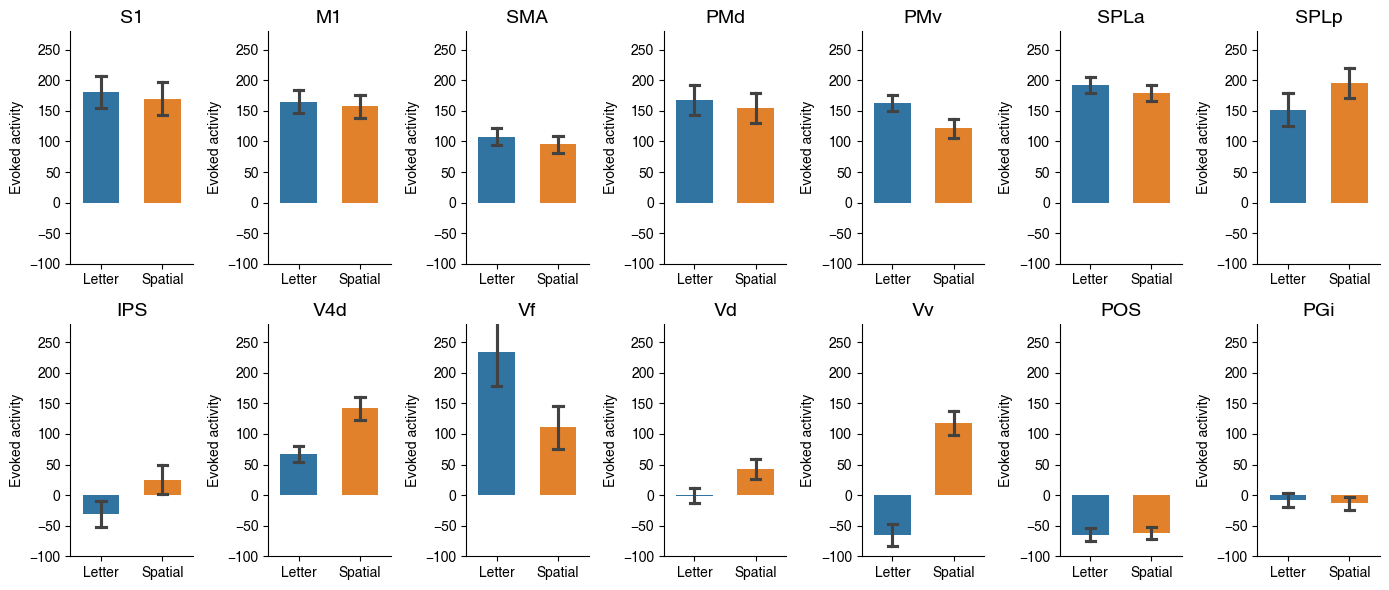

In [61]:
nrows = 2
ncols = 7
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 3*nrows))
axs = np.concatenate(axs)

order = ['letter','spatial']
for ii, roi in enumerate(tqdm(list_roi)):
    ax = axs[ii]
    data = dg[dg.roi==roi].set_index('subj', drop=False)
    g = sns.barplot(
        data=data,
        x='cond', y='value', order=order,
        hue='cond',
        width=0.6,
        capsize=0.15, errorbar='se',
        ax=ax
    )
    # g.grid(axis='both')
    # g.legend().remove()
    # g.legend()
    g.set_ylim(-100,280)
    g.set_ylabel('Evoked activity')
    g.set_xlabel('')
    g.set_xticks([0,1])
    g.set_xticklabels(['Letter','Spatial'])
    g.set_title(roi, fontsize=14)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)

    ## rmANOVA
    print(roi)
    aov = AnovaRM(
        data=data,
        depvar='value',
        subject='subj',
        within=['cond']
    ).fit()
    print(aov)
    # for key, pval in aov.anova_table['Pr > F'].items():
    #     print(key, 'p=%.3e (%s)'%(pval,sstat.convert_pval_to_star(pval)))
    
    ## overall: letter vs. spatial
    a = data[data.cond=='letter'].value.astype(float)
    b = data[data.cond=='spatial'].value.astype(float)
    res = ttest_rel(a,b, alternative='two-sided')
    pval = res.pvalue
    # pval = res.pvalue * len(list_roi)
    print('t(%d)=%.4f, p=%.4f(%s)\n'%(res.df,res.statistic,pval,sstat.convert_pval_to_star(pval)))
    
fig.tight_layout()

## 2. RS Effect

In [28]:
lines = {'category':[],'roi':[],'cond':[],'subj':[],'value':[],'notes':[]}

In [29]:
glm = 2
category = 'RS_effect'

In [30]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [31]:
list_cond = ['wRS','acRS']
# list_cond = ['B','S','C','N']
for ii, cue in enumerate(['letter','spatial']):
    ## Assuming ‘N_cue’ as the baseline (reference).
    fname = join(dir_work,'smooth.cifti.%s.glm_%1d.beta_mean.N_%s.dscalar.nii'%(hem,glm,cue))
    cii = nb.load(fname)
    data = cii.get_fdata()
    ref = extract_data(data=data, mask=mask, list_roi=list_roi)
    
    for jj, cond in enumerate(list_cond):
        fname = join(dir_work,'smooth.cifti.%s.glm_%1d.beta_mean.%s_%s.dscalar.nii'%(hem,glm,cond,cue))
        cii = nb.load(fname)
        data = cii.get_fdata()
        res = extract_data(data=data, mask=mask, list_roi=list_roi)
        for roi, values in res.items():
            a = ref[roi]
            tt = ttest_1samp(a=a, popmean=0, alternative='two-sided')
            if tt.pvalue > 0.05:
                notes = None
            else:
                ## The baseline was coded as ‘+’ when greater than 0, and as ‘–’ when less than 0.
                notes = '+' if tt.statistic > 0 else ('-' if tt.statistic < 0 else 'invalid')
            for kk, value in enumerate(values):
                sn = list_sn[kk]
                subj = 'S'+sn
                lines['category'].append(category)
                lines['roi'].append(roi)
                lines['cond'].append('%s_%s'%(cond,cue))
                lines['subj'].append(subj)
                lines['value'].append(value)
                lines['notes'].append(notes)
dg = pd.DataFrame(lines)
df = pd.concat([df,dg])

In [32]:
idx = dg.cond.isin(['acRS_letter','acRS_spatial'])
tmp = dg[idx].groupby(['category','roi','subj'], as_index=False)['value'].mean()
tmp['cond'] = 'across'
dg = pd.concat([dg[~idx],tmp])
dg['cond'] = dg.cond.replace({
    'wRS_letter': 'letter',
    'wRS_spatial': 'spatial'
})

In [33]:
## rmANOVA
aov = AnovaRM(
    data=dg,
    depvar='value',
    subject='subj',
    within=['cond','roi']
).fit()
pval = aov.anova_table['Pr > F']['cond']
print('%s (%s)'%(roi,sstat.convert_pval_to_star(pval)),aov)
g.set_title('%s (%s)'%(roi,sstat.convert_pval_to_star(pval)), fontsize=14)

PGi (ns)                  Anova
         F Value  Num DF  Den DF  Pr > F
----------------------------------------
cond      3.3776  2.0000  22.0000 0.0526
roi       2.5983 13.0000 143.0000 0.0029
cond:roi  3.2845 26.0000 286.0000 0.0000



Text(0.5, 1.0, 'PGi (ns)')

In [34]:
mapper = {'+': 1, '-': -1}
dg['value'] = dg['value'] * dg['notes'].map(mapper).fillna(1)

  0%|                                                            | 0/14 [00:00<?, ?it/s]

S1 (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.6851 2.0000 22.0000 0.5145

letter vs. spatial: t(11)=-0.8453, p=4.159e-01(ns)

M1 (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.2402 2.0000 22.0000 0.7885

letter vs. spatial: t(11)=-0.4303, p=6.753e-01(ns)



 29%|██████████████▊                                     | 4/14 [00:00<00:00, 30.88it/s]

SMA (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  1.9806 2.0000 22.0000 0.1618

letter vs. spatial: t(11)=-1.3337, p=2.093e-01(ns)

PMd (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.5781 2.0000 22.0000 0.5693

letter vs. spatial: t(11)=-0.0210, p=9.836e-01(ns)

PMv (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  3.0960 2.0000 22.0000 0.0654

letter vs. spatial: t(11)=-1.4221, p=1.827e-01(ns)

SPLa (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  1.3112 2.0000 22.0000 0.2897

letter vs. spatial: t(11)=0.1920, p=8.512e-01(ns)

SPLp (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  1.1026 2.0000 22.0000 0.3497

letter vs. spatial: t(11)=0.6792, p=5.111e-01(ns)



 57%|█████████████████████████████▋                      | 8/14 [00:00<00:00, 31.11it/s]

IPS (*)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  4.0527 2.0000 22.0000 0.0317

letter vs. spatial: t(11)=2.3780, p=3.663e-02(*)

V4d (****)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 28.2040 2.0000 22.0000 0.0000

letter vs. spatial: t(11)=5.8926, p=1.042e-04(***)



 86%|███████████████████████████████████████████▋       | 12/14 [00:00<00:00, 29.40it/s]

Vf (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  1.1875 2.0000 22.0000 0.3238

letter vs. spatial: t(11)=1.0875, p=3.001e-01(ns)

Vd (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.0433 2.0000 22.0000 0.9577

letter vs. spatial: t(11)=0.2576, p=8.014e-01(ns)

Vv (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  2.9619 2.0000 22.0000 0.0726

letter vs. spatial: t(11)=-0.0410, p=9.680e-01(ns)

POS (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  2.1173 2.0000 22.0000 0.1442

letter vs. spatial: t(11)=1.9184, p=8.137e-02(ns)



100%|███████████████████████████████████████████████████| 14/14 [00:00<00:00, 29.39it/s]

PGi (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.5979 2.0000 22.0000 0.5587

letter vs. spatial: t(11)=-0.2240, p=8.268e-01(ns)



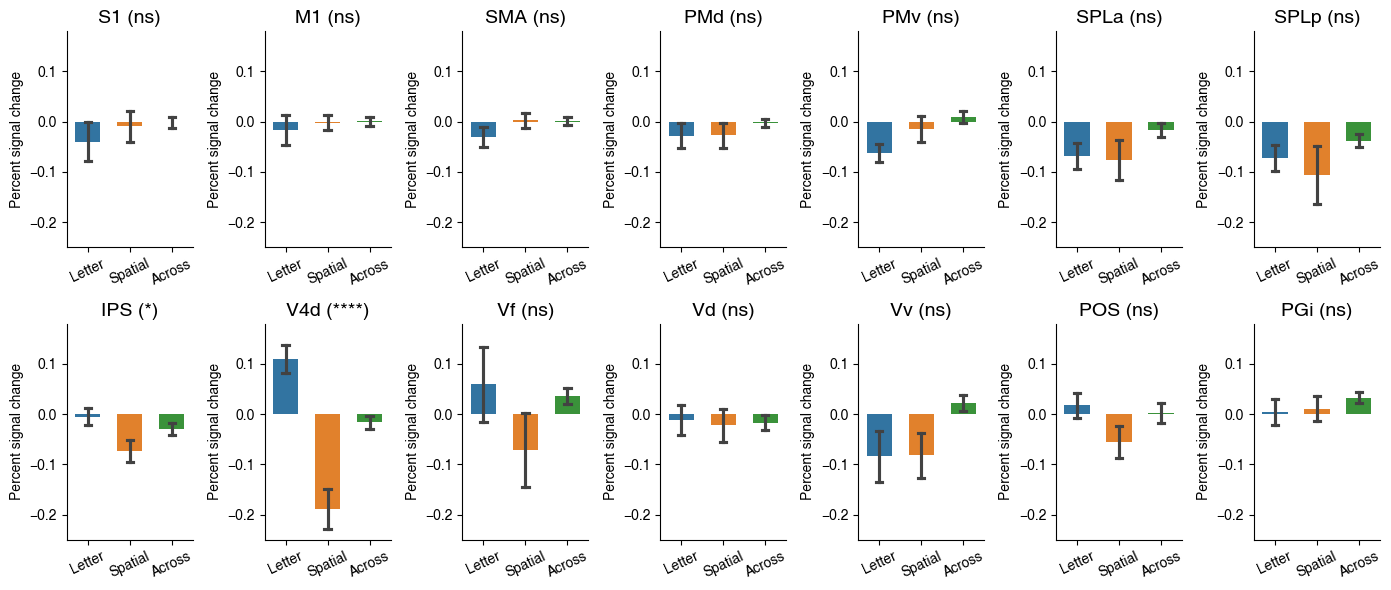

In [35]:
nrows = 2
ncols = 7
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 3*nrows))
axs = np.concatenate(axs)

order = ['letter','spatial','across']
for ii, roi in enumerate(tqdm(list_roi)):
    ax = axs[ii]
    data = dg[dg.roi==roi].set_index('subj', drop=False)
    g = sns.barplot(
        data=data,
        x='cond', y='value', order=order,
        hue='cond',
        width=0.6,
        capsize=0.15, errorbar='se',
        ax=ax
    )
    # g.grid(axis='both')
    # g.legend().remove()
    # g.legend()
    g.set_ylim(-0.25,0.18)
    g.set_ylabel('Percent signal change')
    g.set_xlabel('')
    g.set_xticks([0,1,2])
    g.set_xticklabels(['Letter','Spatial','Across'], rotation=25)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)

    ## rmANOVA
    aov = AnovaRM(
        data=data,
        depvar='value',
        subject='subj',
        within=['cond']
    ).fit()
    pval = aov.anova_table['Pr > F']['cond']
    print('%s (%s)'%(roi,sstat.convert_pval_to_star(pval)),aov)
    g.set_title('%s (%s)'%(roi,sstat.convert_pval_to_star(pval)), fontsize=14)
    
    ## t-test (overall): letter vs. spatial
    a = data[data.cond=='letter'].value.astype(float)
    b = data[data.cond=='spatial'].value.astype(float)
    res = ttest_rel(a,b, alternative='two-sided')
    pval = res.pvalue
    # # pval = res.pvalue * len(list_roi)
    print('letter vs. spatial: t(%d)=%.4f, p=%.3e(%s)\n'%(res.df,res.statistic,pval,sstat.convert_pval_to_star(pval)))
    
fig.tight_layout()

In [36]:
# g = sns.pointplot(
#     data=dg,
#     x='roi', y='value', hue='cond',
#     errorbar='se', capsize=0.15
# )
# g.grid(axis='both')
# g.axhline(y=0, color='black', linestyle='--')
# g.legend()
# l = g.get_xticklabels()
# g.set_xticklabels(l, rotation=40)

In [37]:
# tmp = dg.pivot(index=['category','roi','cond','notes'], columns=['subj'], values='value')
# ## For each ROI and condition, the data from 12 subjects were normalized 
# ## by setting the maximum to 1 and the minimum to 0.
# dg_norm = tmp.sub(tmp.min(axis=1), axis=0).div(tmp.max(axis=1) - tmp.min(axis=1), axis=0)
# dg_norm = dg_norm.reset_index().melt(
#     id_vars=['category','roi','cond','notes'],
#     var_name='subj',
#     value_name='value'
# )
# dg_norm

In [38]:
# g = sns.pointplot(
#     data=dg_norm,
#     x='roi', y='value', hue='cond',
#     errorbar='se', capsize=0.15
# )
# g.grid(axis='both')
# g.legend()
# l = g.get_xticklabels()
# g.set_xticklabels(l, rotation=40)

## 3. RSA

In [39]:
# def map_data2surf(data, mySearchlight):
#     surf = np.ones((data.shape[0],32492)) * np.nan
    
#     ## check the indeces of centers
#     idx = mySearchlight.center_indx
#     for ii, dd in enumerate(data):
#         surf[ii,idx] = dd

#     return surf

In [22]:
lines = {'category':[],'roi':[],'cond':[],'subj':[],'value':[],'notes':[]}

In [23]:
glm = 1
category = 'RSA'

In [24]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [25]:
notes = None
for ii, cue in enumerate(['letter','spatial','across']):
    fname = join(dir_work,'cifti.%s.glm_%1d.searchlight.mean_dist.%s.dscalar.nii'%(hem,glm,cue))
    data = np.array(nb.load(fname).get_fdata())
    res = extract_data(data=data, mask=mask, list_roi=list_roi)
    for roi, values in res.items():
        for kk, value in enumerate(values):
            sn = list_sn[kk]
            subj = 'S'+sn
            lines['category'].append(category)
            lines['roi'].append(roi)
            lines['cond'].append(cue)
            lines['subj'].append(subj)
            lines['value'].append(value)
            lines['notes'].append(notes)
dg = pd.DataFrame(lines)
df = pd.concat([df,dg])

 50%|██████████████████████████                          | 7/14 [00:00<00:00, 30.49it/s]

S1 (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  2.7897 2.0000 22.0000 0.0832

letter vs. spatial: t(11)=-1.3788, p=1.954e-01(ns)

M1 (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  1.9891 2.0000 22.0000 0.1607

letter vs. spatial: t(11)=-1.3443, p=2.059e-01(ns)

SMA (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.6946 2.0000 22.0000 0.5099

letter vs. spatial: t(11)=0.3521, p=7.314e-01(ns)

PMd (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.9808 2.0000 22.0000 0.3908

letter vs. spatial: t(11)=-0.8915, p=3.917e-01(ns)

PMv (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.3783 2.0000 22.0000 0.6894

letter vs. spatial: t(11)=0.4598, p=6.546e-01(ns)

SPLa (ns)               Anova
     F Value Num DF  Den DF Pr > F
----

100%|███████████████████████████████████████████████████| 14/14 [00:00<00:00, 28.60it/s]

IPS (*)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  3.6558 2.0000 22.0000 0.0426

letter vs. spatial: t(11)=-2.0832, p=6.136e-02(ns)

V4d (**)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  5.9676 2.0000 22.0000 0.0085

letter vs. spatial: t(11)=-2.4782, p=3.067e-02(*)

Vf (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  1.7280 2.0000 22.0000 0.2009

letter vs. spatial: t(11)=-1.2540, p=2.359e-01(ns)

Vd (**)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  9.4649 2.0000 22.0000 0.0011

letter vs. spatial: t(11)=-2.7665, p=1.834e-02(*)

Vv (****)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 17.2498 2.0000 22.0000 0.0000

letter vs. spatial: t(11)=-4.1929, p=1.504e-03(**)

POS (ns)               Anova
     F Value Num DF  Den DF Pr > F
-----

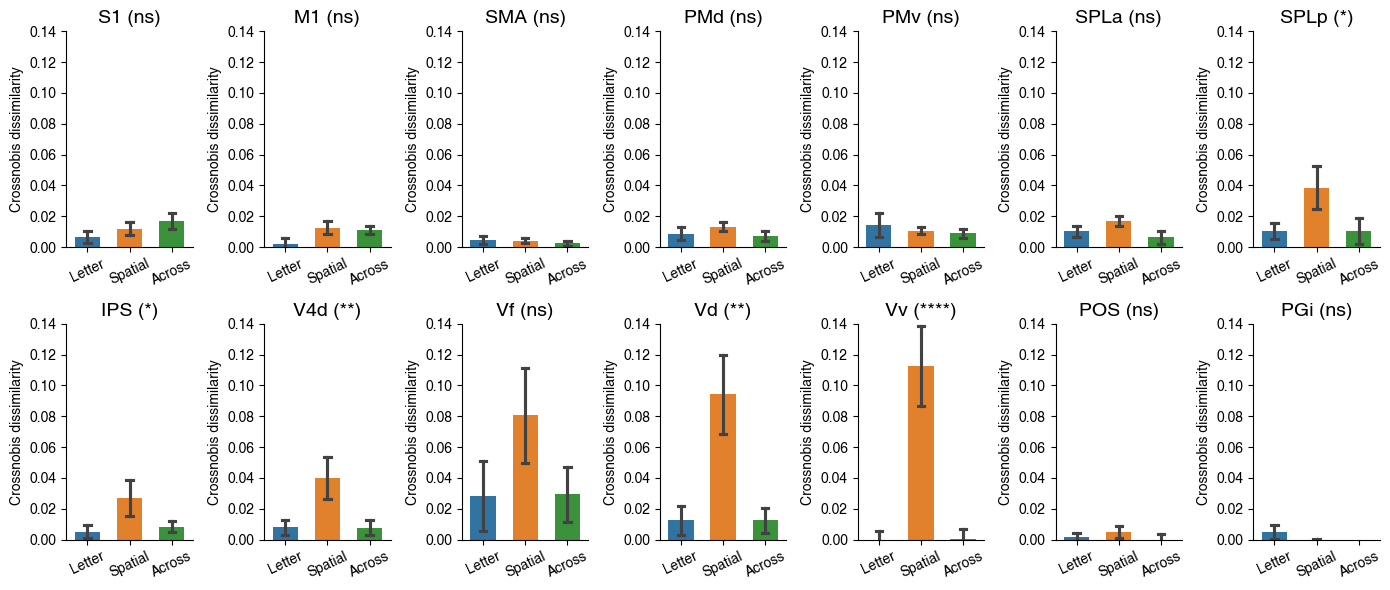

In [26]:
nrows = 2
ncols = 7
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 3*nrows))
axs = np.concatenate(axs)

order = ['letter','spatial','across']
for ii, roi in enumerate(tqdm(list_roi)):
    ax = axs[ii]
    data = dg[dg.roi==roi].set_index('subj', drop=False)
    g = sns.barplot(
        data=data,
        x='cond', y='value', order=order,
        hue='cond',
        width=0.6,
        capsize=0.15, errorbar='se',
        ax=ax
    )
    # g.grid(axis='both')
    # g.legend().remove()
    # g.legend()
    g.set_ylim(0,0.14)
    g.set_ylabel('Crossnobis dissimilarity')
    g.set_xlabel('')
    g.set_xticks([0,1,2])
    g.set_xticklabels(['Letter','Spatial','Across'], rotation=25)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)

    ## rmANOVA
    aov = AnovaRM(
        data=data,
        depvar='value',
        subject='subj',
        within=['cond']
    ).fit()
    pval = aov.anova_table['Pr > F']['cond']
    print('%s (%s)'%(roi,sstat.convert_pval_to_star(pval)),aov)
    g.set_title('%s (%s)'%(roi,sstat.convert_pval_to_star(pval)), fontsize=14)
    
    ## t-test (overall): letter vs. spatial
    a = data[data.cond=='letter'].value.astype(float)
    b = data[data.cond=='spatial'].value.astype(float)
    res = ttest_rel(a,b, alternative='two-sided')
    pval = res.pvalue
    # # pval = res.pvalue * len(list_roi)
    print('letter vs. spatial: t(%d)=%.4f, p=%.3e(%s)\n'%(res.df,res.statistic,pval,sstat.convert_pval_to_star(pval)))
    
fig.tight_layout()

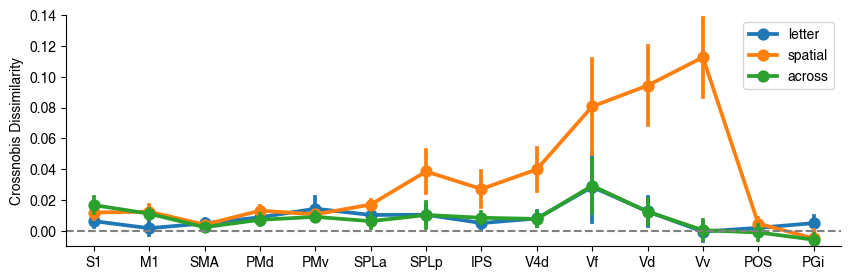

In [27]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 3*nrows))

g = sns.pointplot(
    data=dg,
    x='roi', y='value', order=list_roi,
    hue='cond', hue_order=['letter','spatial','across'],
    capsize=0, errorbar='se',
    ax=ax
)
# g.grid(axis='both')
# g.legend().remove()
g.legend()
g.axhline(y=0, linestyle='--', color='gray')
g.set_ylim(-0.01,0.14)
g.set_ylabel('Crossnobis Dissimilarity')
g.set_xlabel('')
# g.set_xticks([0,1,2])
# g.set_xticklabels(['Letter','Spatial','Across'], rotation=25)
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

### i) Save the `df`

In [47]:
fname = join(dir_group,'GLMsingle.ROI.csv')
df.to_csv(fname, index=False, encoding="utf-8")

---
---

In [61]:
def plot_df(df=None):
    nrows = 2
    ncols = 7
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axs = np.concatenate(axs)
    
    order = ['overall','RSA','RS_effect']
    hue_order = ['letter','spatial','across']
    for ii, roi in enumerate(tqdm(list_roi)):
        ax = axs[ii]
        data = df[df.roi==roi]
        g = sns.barplot(
            data=data,
            x='category', y='value', hue='cond',
            order=order,
            hue_order=hue_order,
            capsize=0.15, errorbar='se',
            ax=ax
        )
        # g.set_ylim(-0.01,0.01)
        g.grid(axis='both')
        # g.legend().remove()
        g.legend()
        g.set_title(roi, fontsize=14)

        ## overall: letter vs. spatial
        a = df_norm[(df_norm.roi==roi)&(df_norm.category=='overall')&(df_norm.cond=='letter')].value
        b = df_norm[(df_norm.roi==roi)&(df_norm.category=='overall')&(df_norm.cond=='spatial')].value
        res = ttest_rel(a,b, alternative='two-sided')
        print('overall', roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
    
    ## one sample t-test
    dx = 1.1/(len(hue_order)+1)
    for ii, roi in enumerate(list_roi):
        ax = axs[ii]
        ylim = np.array(ax.get_ylim())
        dy = np.diff(ylim)[0] * 0.02
        ax.set_ylim(ylim*1.02)
        for jj, category in enumerate(order):
            for kk, cond in enumerate(hue_order):
                x = jj + dx*(kk-1.01)
                a = df[(df.roi==roi)&(df.category==category)&(df.cond==cond)].value.astype(float)
                if len(a)==0:
                    continue
                ##
                res = ttest_1samp(a=a, popmean=0, alternative='two-sided')
                if res.pvalue < 0.05:
                    # print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
                    y = a.mean()
                    if a.mean() > 0:
                         y += a.sem() + dy
                    else:
                        y -= a.sem() + 2*dy
                        
                    ax.text(
                        x=x, y=y,
                        s=sstat.convert_pval_to_star(res.pvalue), fontsize=12,
                        color='black',
                        ha='center', va='center'
                    )
                    
    fig.tight_layout()

In [49]:
def func_normalize(x):
    xmin = x.min()
    xmax = x.max()
    # res = (x - xmin)/(xmax - xmin)
    res = x/(xmax - xmin)
    return res

In [50]:
def plot_df_vs_df_norm(df=None, df_norm=None):
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,12))
    
    for ii, category in enumerate(['overall','RSA','RS_effect']):
        for jj, data in enumerate([df, df_norm]):
            ax = axs[ii,jj]
            tmp = data[data.category==category].value
            sns.histplot(tmp, ax=ax)
            ax.set_title(category)
            ax.grid(axis='y', linestyle='--')
    fig.tight_layout()

### ii) Load the `df`

In [51]:
fname = join(dir_group,'GLMsingle.ROI.csv')
df = pd.read_csv(fname, encoding="utf-8")

---

### Reflect Repetition Effect

In [52]:
## If the signs of the baseline (‘notes’) and the contrast (‘value’) are different, 
## it is classified as an RS effect; if the signs are the same, it is classified as an RE effect.
mapper = {'+': 1, '-': -1}
# df['value_'] = df['value'] * df['notes'].map(mapper).fillna(1)

In [53]:
# df[(df.category=='RS_effect')&(df.roi=='BA7')]
# df[(df.category=='RS_effect')&(df.notes=='-')]
# df[(df.category=='RS_effect')&(df.notes=='+')]

---

### Normalization Method #1 (Correct!)

In [54]:
value_cols = ['value']
df_norm = df.copy()
df_norm[[c+'N' for c in value_cols]] = df.groupby('category')[value_cols].transform(func_normalize)
df_norm

,category,roi,cond,subj,value,notes,valueN
0,overall,S1,letter,S01,138.570632,NaN,0.175559
1,overall,S1,letter,S02,112.226629,NaN,0.142183
2,overall,S1,letter,S03,93.983156,NaN,0.119070
3,overall,S1,letter,S05,190.969289,NaN,0.241945
4,overall,S1,letter,S06,177.350423,NaN,0.224691
...,...,...,...,...,...,...,...
1507,RSA,PGi,across,S10,0.003174,NaN,0.007285
1508,RSA,PGi,across,S11,0.009216,NaN,0.021150
1509,RSA,PGi,across,S12,-0.012055,NaN,-0.027665
1510,RSA,PGi,across,S13,-0.002806,NaN,-0.006440


In [55]:
df_norm['value'] = df_norm['valueN'] * df_norm['notes'].map(mapper).fillna(1)
df_norm['cond'] = df_norm.cond.replace({
    'wRS_letter': 'letter',
    'wRS_spatial': 'spatial'
})
df_norm.drop(columns=['notes','valueN'], inplace=True)
df_norm

,category,roi,cond,subj,value
0,overall,S1,letter,S01,0.175559
1,overall,S1,letter,S02,0.142183
2,overall,S1,letter,S03,0.119070
3,overall,S1,letter,S05,0.241945
4,overall,S1,letter,S06,0.224691
...,...,...,...,...,...
1507,RSA,PGi,across,S10,0.007285
1508,RSA,PGi,across,S11,0.021150
1509,RSA,PGi,across,S12,-0.027665
1510,RSA,PGi,across,S13,-0.006440


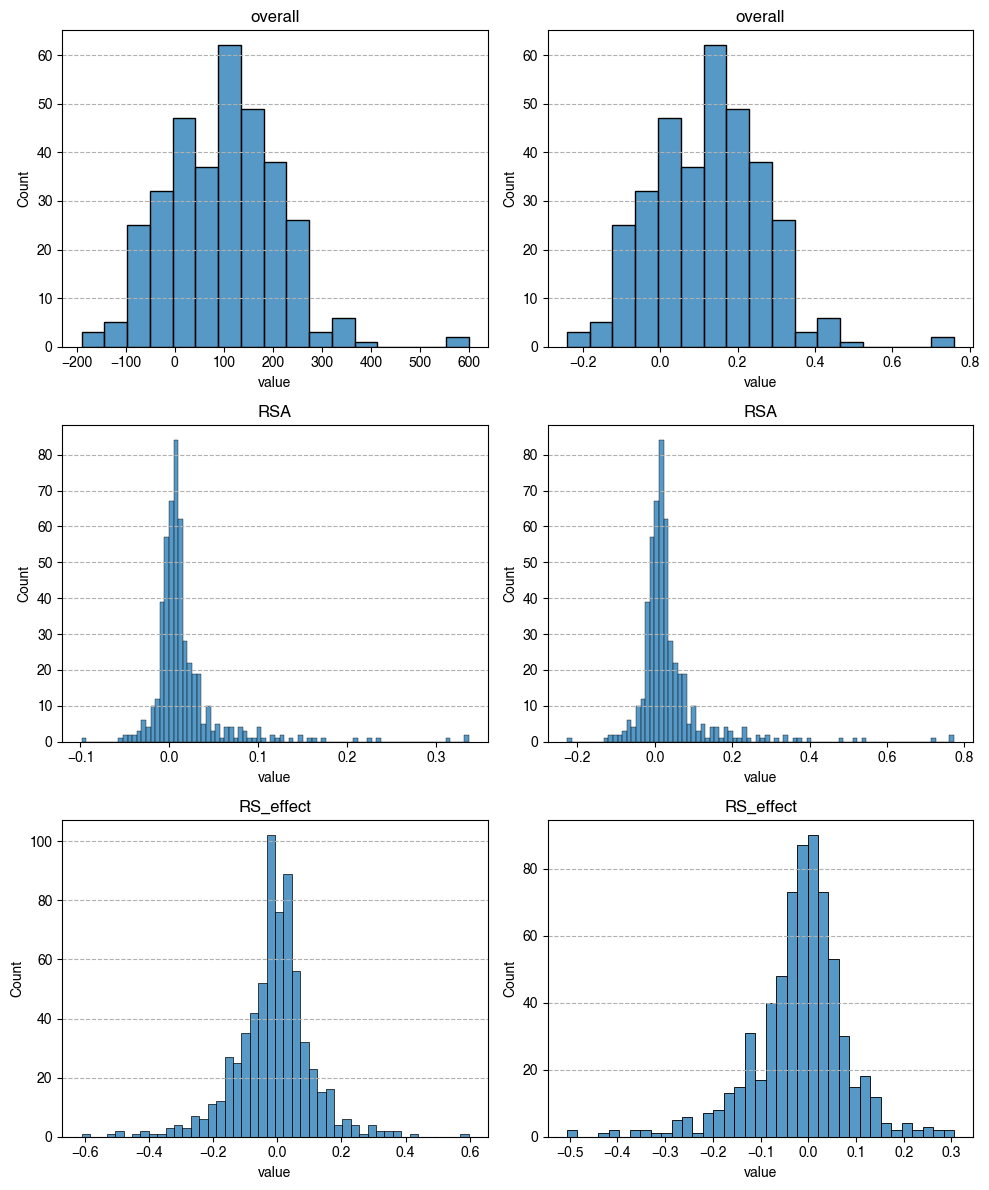

In [56]:
plot_df_vs_df_norm(df=df, df_norm=df_norm)

In [57]:
# 1. cond가 acRS_letter 또는 acRS_spatial인 경우만 선택
# df_sub = df_norm[df_norm.cond.str.contains('acRS', na=False)]
mask = df_norm.cond.isin(['acRS_letter','acRS_spatial'])
df_sub = df_norm[mask]
df_sub

,category,roi,cond,subj,value
504,RS_effect,S1,acRS_letter,S01,0.001497
505,RS_effect,S1,acRS_letter,S02,-0.119303
506,RS_effect,S1,acRS_letter,S03,-0.017659
507,RS_effect,S1,acRS_letter,S05,-0.010497
508,RS_effect,S1,acRS_letter,S06,-0.019021
...,...,...,...,...,...
1003,RS_effect,PGi,acRS_spatial,S10,0.097181
1004,RS_effect,PGi,acRS_spatial,S11,0.002878
1005,RS_effect,PGi,acRS_spatial,S12,0.068753
1006,RS_effect,PGi,acRS_spatial,S13,0.059080


In [58]:
# 2. category, roi, subj별로 그룹화 후 value 평균 계산
df_mean = df_sub.groupby(['category','roi','subj'], as_index=False)['value'].mean()
df_mean['cond'] = 'across'
df_mean

,category,roi,subj,value,cond
0,RS_effect,IPS,S01,-0.029864,across
1,RS_effect,IPS,S02,0.041952,across
2,RS_effect,IPS,S03,-0.080056,across
3,RS_effect,IPS,S05,-0.010552,across
4,RS_effect,IPS,S06,-0.045645,across
...,...,...,...,...,...
163,RS_effect,Vv,S10,-0.073517,across
164,RS_effect,Vv,S11,-0.281951,across
165,RS_effect,Vv,S12,-0.113848,across
166,RS_effect,Vv,S13,-0.464383,across


In [59]:
# 3. 원본에서 'acRS'행들은 모두 삭제 한 후에 병합
df_norm = df_norm[~df_norm.cond.str.contains('acRS', na=False)]
df_norm = pd.concat([df_norm, df_mean])
df_norm

,category,roi,cond,subj,value
0,overall,S1,letter,S01,0.175559
1,overall,S1,letter,S02,0.142183
2,overall,S1,letter,S03,0.119070
3,overall,S1,letter,S05,0.241945
4,overall,S1,letter,S06,0.224691
...,...,...,...,...,...
163,RS_effect,Vv,across,S10,-0.073517
164,RS_effect,Vv,across,S11,-0.281951
165,RS_effect,Vv,across,S12,-0.113848
166,RS_effect,Vv,across,S13,-0.464383


 43%|██████████████████████▎                             | 6/14 [00:00<00:00, 25.23it/s]

overall S1 t(11)=3.4597, p=5.336e-03(**)
overall M1 t(11)=3.0597, p=1.086e-02(*)
overall SMA t(11)=4.1741, p=1.552e-03(**)
overall PMd t(11)=2.7653, p=1.838e-02(*)
overall PMv t(11)=6.1913, p=6.799e-05(****)
overall SPLa t(11)=2.4130, p=3.443e-02(*)
overall SPLp t(11)=-2.4063, p=3.484e-02(*)


 86%|███████████████████████████████████████████▋       | 12/14 [00:00<00:00, 16.16it/s]

overall IPS t(11)=-5.7237, p=1.334e-04(***)
overall V4d t(11)=-5.5198, p=1.808e-04(***)
overall Vf t(11)=3.1820, p=8.730e-03(**)
overall Vd t(11)=-3.7369, p=3.284e-03(**)
overall Vv t(11)=-10.4387, p=4.806e-07(****)


100%|███████████████████████████████████████████████████| 14/14 [00:00<00:00, 17.16it/s]


overall POS t(11)=-0.4970, p=6.290e-01(ns)
overall PGi t(11)=1.8125, p=9.726e-02(ns)


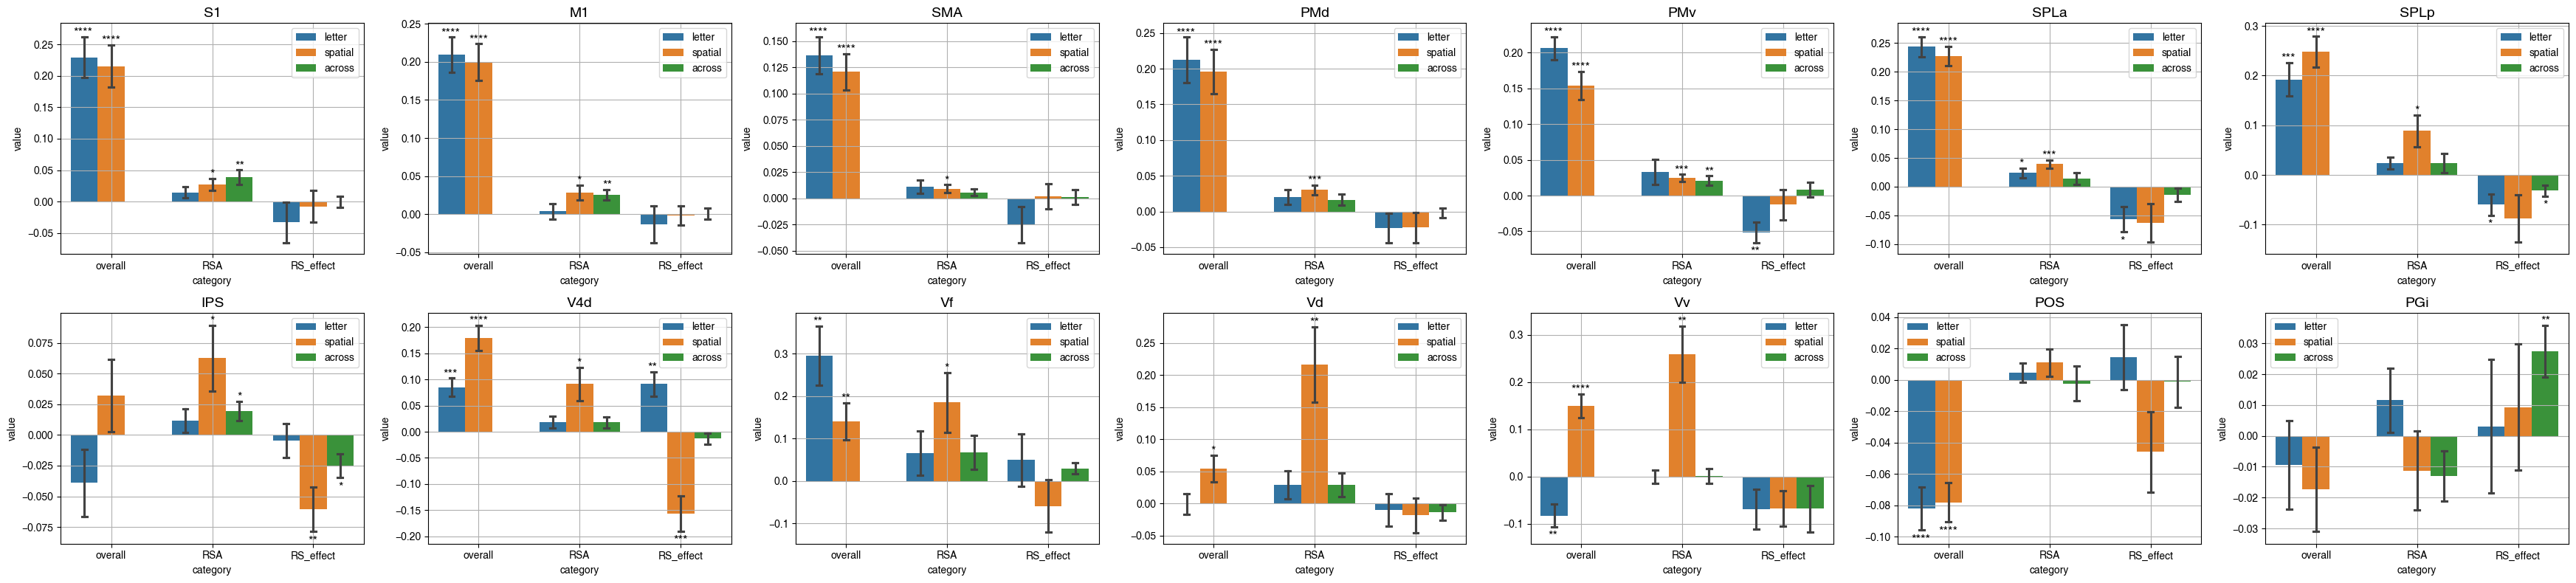

In [62]:
plot_df(df=df_norm)

---
---

### Normalization Method #2 (Wrong!)

In [42]:
dg = df.pivot(index=['category','roi','cond'], columns=['subj'], values='value_')
dg

subj                         S01         S02         S03         S05  \
category roi cond                                                      
RSA      BA7 across     0.006827   -0.012745    0.002612   -0.011533   
             letter     0.011170    0.033133   -0.000943    0.004717   
             spatial   -0.006667   -0.008182    0.039089    0.033419   
         IP  across    -0.016488   -0.002552   -0.006684   -0.014217   
             letter     0.024100    0.045482    0.016560    0.009304   
...                          ...         ...         ...         ...   
overall  V3d spatial  107.510250  -46.176082   43.471492   33.326458   
         V3m letter   642.909011  269.620910   37.627607   74.108363   
             spatial  155.395604    2.490909  119.352504   -1.725614   
         V3v letter   -66.023298 -115.575810  -74.313922 -135.806126   
             spatial  173.109570  140.624507  162.289907  -48.105313   

subj                         S06         S08        S09         S10  \
category roi cond                                                     
RSA      BA7 across     0.001709    0.014683  -0.002129    0.002491   
             letter    -0.000702   -0.001513   0.009605   -0.010021   
             spatial    0.010528   -0.002414  -0.006292    0.010552   
         IP  across     0.008561   -0.007314   0.004346    0.009725   
             letter     0.011121    0.007534  -0.003006   -0.000006   
...                          ...         ...        ...         ...   
overall  V3d spatial   34.016398  -27.932115 -58.583212  -40.693979   
         V3m letter   193.356247  161.526426  42.237896   67.301982   
             spatial   41.959797   18.916769  29.734942  -18.352115   
         V3v letter    13.273700 -176.223419   5.675444 -233.869273   
             spatial  137.255610    9.196991  68.511737   -7.299649   

subj                         S11         S12         S13         S14  
category roi cond                                                     
RSA      BA7 across     0.013225   -0.009636   -0.001376   -0.014629  
             letter     0.024928   -0.003448   -0.010812   -0.000716  
             spatial    0.009923   -0.029589    0.002501    0.008783  
         IP  across     0.036196   -0.001713    0.019402    0.011338  
             letter     0.041031    0.004510   -0.002260   -0.004866  
...                          ...         ...         ...         ...  
overall  V3d spatial  116.215519  123.510009   -1.982136  -41.137974  
         V3m letter   660.846172  287.826709  424.001287  249.113275  
             spatial  262.365085   74.808596  319.084765   23.351370  
         V3v letter  -145.205684  -89.362272 -340.251855 -117.547976  
             spatial   91.364750   59.182621   46.958284  -21.992694  

[198 rows x 12 columns]

In [ ]:
dg = df.pivot(index=['category','roi','cond'], columns=['subj'], values='value')
## Determine whether the mean value of each row is negative
row_mean = dg.mean(axis=1)

In [44]:
## For each ROI and condition, the data from 12 subjects were normalized 
## by setting the maximum to 1 and the minimum to 0. (Min-Max normalization)
dg_norm = dg.groupby(level='category').transform(func_normalize) # category
# dg_norm = dg.sub(dg.min(axis=1), axis=0).div(dg.max(axis=1) - dg.min(axis=1), axis=0)

## Conditionally transform the values to the range [-1, 0]
dg_norm = dg_norm.mask(row_mean.lt(0), -dg_norm)

dg_norm

subj                       S01       S02       S03       S05       S06  \
category roi cond                                                        
RSA      BA7 across  -0.066498 -0.109588 -0.483710 -0.147953 -0.295844   
             letter   0.075760  0.238999  0.464471  0.232141  0.276524   
             spatial  0.037713  0.122458  0.681139  0.380833  0.366500   
         IP  across   0.016764  0.138340  0.433397  0.134050  0.350744   
             letter   0.103342  0.273833  0.559201  0.255905  0.371250   
...                        ...       ...       ...       ...       ...   
overall  V3d spatial  0.275857  0.362411  0.318365  0.422552  0.310356   
         V3m letter   1.000000  1.000000  0.302569  0.504484  0.782509   
             spatial  0.340623  0.460669  0.523465  0.352132  0.333894   
         V3v letter  -0.041147 -0.222295 -0.000000 -0.082761 -0.248892   
             spatial  0.364582  0.739559  0.639521  0.258954  0.616273   

subj                       S08       S09       S10       S11       S12  \
category roi cond                                                        
RSA      BA7 across  -0.254012 -0.346271 -0.472498 -0.256139 -0.150605   
             letter   0.169382  0.400913  0.407567  0.279523  0.180918   
             spatial  0.164674  0.326881  0.514330  0.249541  0.052862   
         IP  across   0.139075  0.376422  0.510038  0.302036  0.189414   
             letter   0.216658  0.342188  0.459538  0.311697  0.219899   
...                        ...       ...       ...       ...       ...   
overall  V3d spatial  0.394020  0.000000  0.406666  0.443896  0.616054   
         V3m letter   0.897424  0.343635  0.634015  1.000000  0.950815   
             spatial  0.518501  0.301021  0.453699  0.593124  0.516834   
         V3v letter  -0.000000 -0.219017 -0.000000 -0.176967 -0.182370   
             spatial  0.492675  0.433186  0.476967  0.418521  0.485000   

subj                       S13       S14  
category roi cond                         
RSA      BA7 across  -0.091714 -0.171125  
             letter   0.069529  0.269157  
             spatial  0.100829  0.336090  
         IP  across   0.140561  0.354090  
             letter   0.089635  0.239915  
...                        ...       ...  
overall  V3d spatial  0.427006  0.230888  
         V3m letter   0.964734  0.957539  
             spatial  0.832296  0.392339  
         V3v letter  -0.000000 -0.039594  
             spatial  0.488784  0.278819  

[198 rows x 12 columns]

In [45]:
df_norm = dg_norm.reset_index().melt(
    id_vars=['category','roi','cond'],
    var_name='subj',
    value_name='value'
)
df_norm['cond'] = df_norm.cond.replace({
    'wRS_letter': 'letter',
    'wRS_spatial': 'spatial'
})
df_norm

,category,roi,cond,subj,value
0,RSA,BA7,across,S01,-0.066498
1,RSA,BA7,letter,S01,0.075760
2,RSA,BA7,spatial,S01,0.037713
3,RSA,IP,across,S01,0.016764
4,RSA,IP,letter,S01,0.103342
...,...,...,...,...,...
2371,overall,V3d,spatial,S14,0.230888
2372,overall,V3m,letter,S14,0.957539
2373,overall,V3m,spatial,S14,0.392339
2374,overall,V3v,letter,S14,-0.039594


---